Training LogisticRegression...

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.05      0.07      1688
           1       0.10      0.01      0.01      1481
           2       0.13      0.20      0.16      1899
           3       0.11      0.03      0.05      1604
           4       0.20      0.01      0.02      1604
           5       0.21      0.54      0.30      1796
           6       0.13      0.49      0.21      2216
           7       0.43      0.00      0.00      1621
           8       0.11      0.03      0.05      1714
           9       0.16      0.25      0.19      1346
          10       0.14      0.01      0.01      1565
          11       0.11      0.02      0.04      1466

    accuracy                           0.15     20000
   macro avg       0.16      0.14      0.09     20000
weighted avg       0.16      0.15      0.10     20000



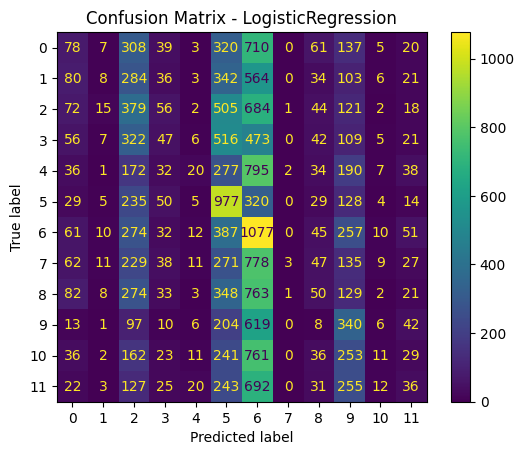

Training RandomForest...

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.11      0.11      1688
           1       0.10      0.09      0.10      1481
           2       0.13      0.14      0.13      1899
           3       0.14      0.14      0.14      1604
           4       0.11      0.10      0.11      1604
           5       0.34      0.45      0.39      1796
           6       0.14      0.17      0.15      2216
           7       0.10      0.08      0.09      1621
           8       0.10      0.09      0.10      1714
           9       0.23      0.25      0.24      1346
          10       0.12      0.10      0.11      1565
          11       0.12      0.11      0.11      1466

    accuracy                           0.15     20000
   macro avg       0.15      0.15      0.15     20000
weighted avg       0.15      0.15      0.15     20000



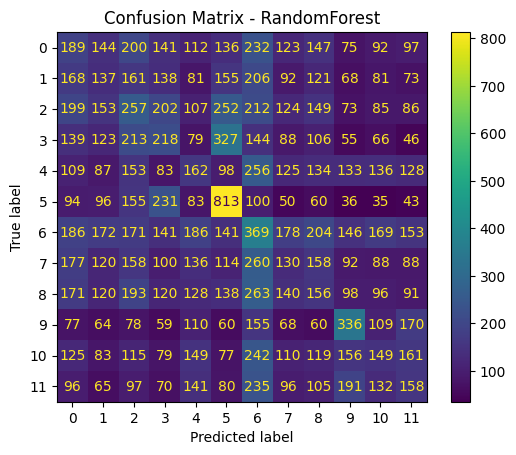

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.09      0.10      1688
           1       0.10      0.06      0.07      1481
           2       0.14      0.15      0.15      1899
           3       0.16      0.14      0.15      1604
           4       0.13      0.08      0.10      1604
           5       0.33      0.54      0.41      1796
           6       0.14      0.24      0.17      2216
           7       0.10      0.06      0.08      1621
           8       0.12      0.09      0.10      1714
           9       0.23      0.35      0.27      1346
          10       0.12      0.08      0.10      1565
          11       0.13      0.11      0.12      1466

    accuracy                           0.17     20000
   macro avg       0.15      0.17      0.15     20000
weighted avg       0.15      0.17      0.15     20000



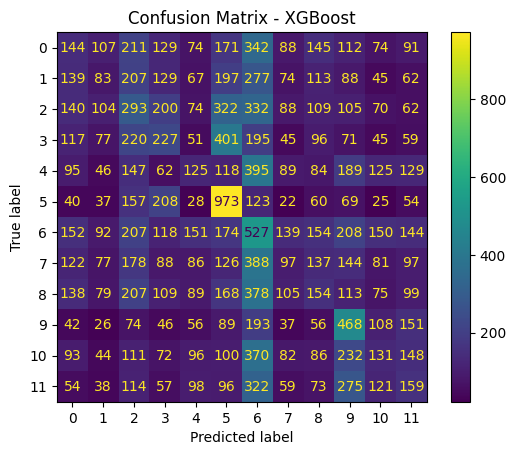

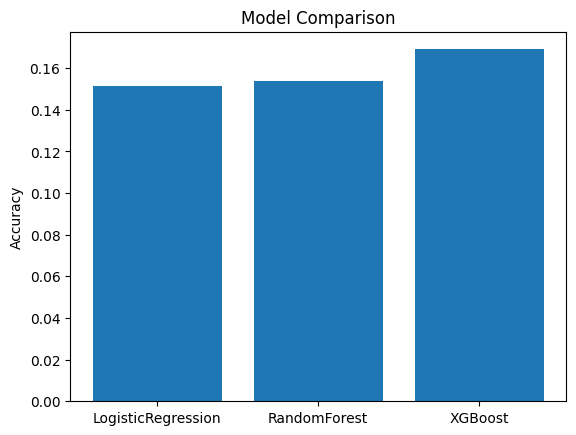

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import joblib

# Load dataset
df = pd.read_csv('2024_clean.csv')
df = df.tail(100000)

# Define main label and features
main_label = 'FlightDelay'
selected_features = ['MKT_UNIQUE_CARRIER', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'DEP_DELAY', 'DISTANCE', 'Day', 'DepTime_sin', 'DepTime_cos']

# Split features into numerical and categorical
numerical_features = df[selected_features].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df[selected_features].select_dtypes(include=['object']).columns.tolist()

# Automatically distinguish high-cardinality categorical features
low_cardinality_features = [col for col in categorical_features if df[col].nunique() <= 20]
high_cardinality_features = [col for col in categorical_features if df[col].nunique() > 20]

# Encode target variable
target_encoder = LabelEncoder()
df[main_label] = target_encoder.fit_transform(df[main_label])
joblib.dump(target_encoder, 'label_encoder.pkl')

# Split data into train and test
X = df[selected_features]
y = df[main_label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical, low-cardinality, and high-cardinality features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('low_cat', OneHotEncoder(handle_unknown='ignore'), low_cardinality_features),
        ('high_cat', TargetEncoder(), high_cardinality_features)
    ]
)

# Define models
models = {
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100))
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    # Save the model
    joblib.dump(model, f'{name}_model.pkl')

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Compare model performances
plt.bar(results.keys(), results.values())
plt.title("Model Comparison")
plt.ylabel("Accuracy")
plt.show()

# Plot learning curve for the best model (example: Random Forest)
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label="Training score")
    plt.plot(train_sizes, test_scores_mean, label="Validation score")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_learning_curve(models['RandomForest'], X, y, "Learning Curve - Random Forest")
